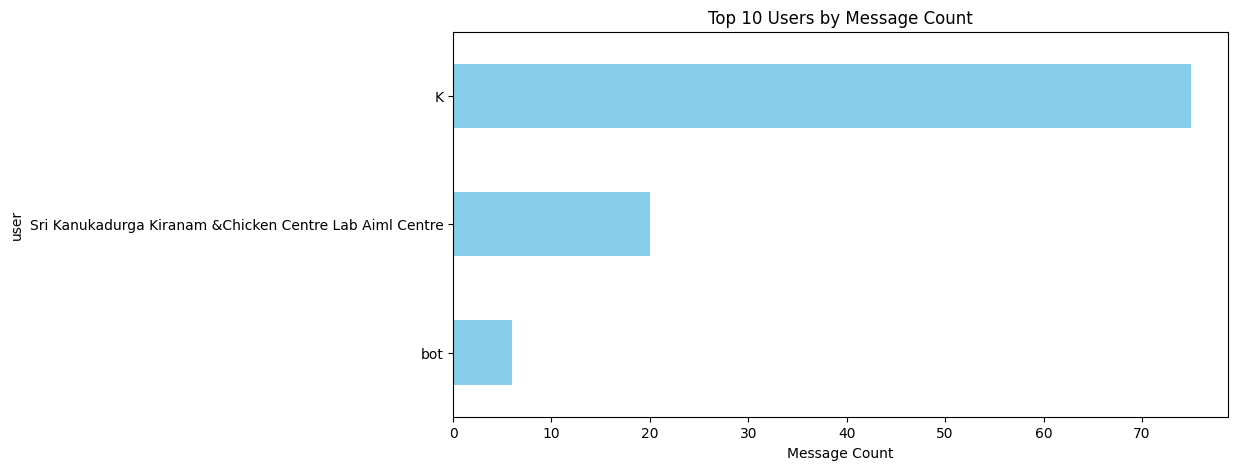

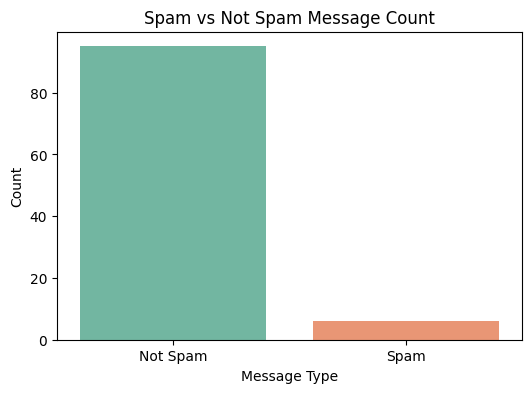

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


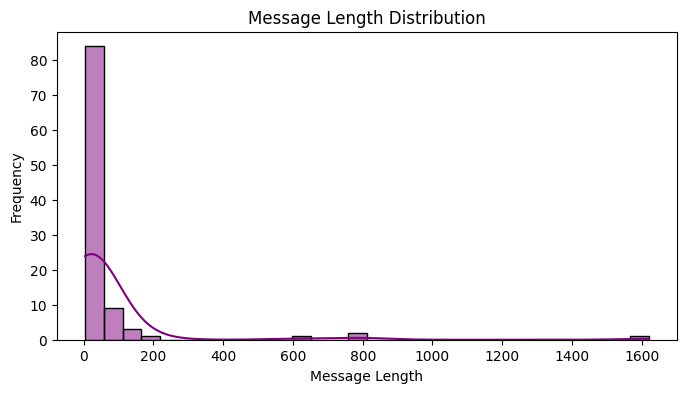

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


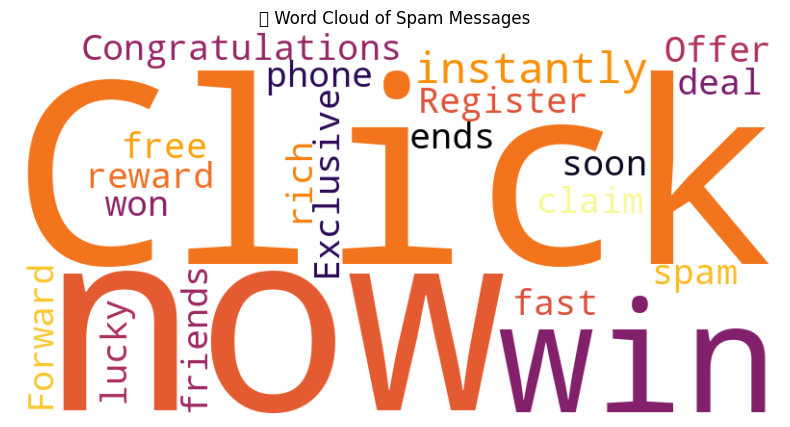

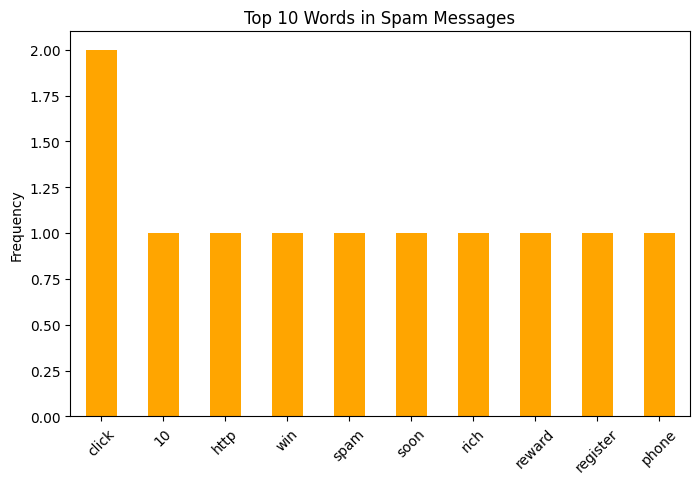

✅ Accuracy: 0.9523809523809523

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.00      0.00      0.00         1

    accuracy                           0.95        21
   macro avg       0.48      0.50      0.49        21
weighted avg       0.91      0.95      0.93        21

Message: Click here to win ₹500 instantly!
Prediction: Not Spam


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# File path
file_path = '/kaggle/input/ss-chat/WhatsApp Chat with Sri Kanukadurga Kiranam and Chicken Centre Lab Aiml Centre.txt'

# Preprocessing function
def preprocess_chat(chat_file):
    with open(chat_file, 'r', encoding='utf-8') as file:
        data = file.read()

    pattern = r'(\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}(?:\s[APMapm]{2})?)\s-\s'
    messages = re.split(pattern, data)[1:]
    chat_data = []

    for i in range(0, len(messages) - 1, 2):
        datetime = messages[i]
        content = messages[i + 1]
        split_msg = re.split(r':\s', content, maxsplit=1)
        if len(split_msg) == 2:
            user, msg = split_msg
        else:
            user, msg = 'system', split_msg[0]
        chat_data.append([datetime, user, msg])

    return pd.DataFrame(chat_data, columns=["datetime", "user", "message"])

# Load and clean data
df = preprocess_chat(file_path)
df = df[df['message'].notna()]
df['message'] = df['message'].str.strip()
df = df[df['message'] != '']
df = df[df['message'].str.len() > 3]
df = df[~df['message'].str.contains("Media omitted", case=False, na=False)]
df = df[~df['message'].str.contains("end-to-end encrypted", case=False, na=False)]

# Add labeled spam samples
extra_spam = pd.DataFrame({
    'datetime': ['dummy']*6,
    'user': ['bot']*6,
    'message': [
        'Click here to win ₹1000 instantly!',
        'Congratulations! You won a free phone. Click now!',
        'Get rich fast: http://spam.com',
        'Register now and claim your reward!',
        'Exclusive deal: 50% OFF! Offer ends soon.',
        'Forward this to 10 friends and get lucky!'
    ],
    'label': [1]*6
})

df['label'] = 0  # Not spam by default
df = pd.concat([df, extra_spam], ignore_index=True)

# ➕ EDA Graphs Below

# 📌 Message count per user
plt.figure(figsize=(10, 5))
df['user'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.xlabel('Message Count')
plt.title('Top 10 Users by Message Count')
plt.gca().invert_yaxis()
plt.show()

# 📌 Spam vs Not Spam Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='Set2')
plt.xticks([0, 1], ['Not Spam', 'Spam'])
plt.title('Spam vs Not Spam Message Count')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

# 📌 Message length distribution
df['msg_len'] = df['message'].str.len()
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='msg_len', bins=30, kde=True, color='purple')
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

# 📌 WordCloud of Spam Messages
spam_text = " ".join(df[df['label'] == 1]['message'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(spam_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('🌐 Word Cloud of Spam Messages')
plt.show()

# 📌 Top Spam Words (bar chart)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
spam_words = cv.fit_transform(df[df['label'] == 1]['message'])

word_freq = pd.DataFrame(spam_words.toarray(), columns=cv.get_feature_names_out())
top_spam_words = word_freq.sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
top_spam_words.plot(kind='bar', color='orange')
plt.title('Top 10 Words in Spam Messages')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# ➕ Spam Detection Model
X = df['message']
y = df['label']

tfidf = TfidfVectorizer(stop_words='english')
X_vec = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# ➕ Function to predict new message
def predict_message(msg):
    vec = tfidf.transform([msg])
    pred = model.predict(vec)[0]
    return "Spam" if pred == 1 else "Not Spam"

# Test
test_msg = "Click here to win ₹500 instantly!"
print("Message:", test_msg)
print("Prediction:", predict_message(test_msg)) 